# **How Fast Delivery Builds Trust: E-Commerce Data Analysis**
An analysis of Brazillian E-Commerce transactions made at [Olist Store](www.olist.com).

**Created By:** *Fritz Immanuel & Gerard Louis Howan* (JCDS 2502)

### **Import Libraries & Dataset**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # display all columns, without limits
pd.set_option('display.max_colwidth', None)

In [2]:
# load dataset
customers_df = pd.read_csv('dataset/raw/olist_customers_dataset.csv')

orders_df = pd.read_csv('dataset/raw/olist_orders_dataset.csv')
order_items_df = pd.read_csv('dataset/raw/olist_order_items_dataset.csv')
order_payments_df = pd.read_csv('dataset/raw/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('dataset/raw/olist_order_reviews_dataset.csv')

products_df = pd.read_csv('dataset/raw/olist_products_dataset.csv')
pcateg_translation_df = pd.read_csv('dataset/raw/product_category_name_translation.csv')

sellers_df = pd.read_csv('dataset/raw/olist_sellers_dataset.csv')

geolocation_df = pd.read_csv('dataset/raw/olist_geolocation_dataset.csv')

## **> Introduction**

<hr>

[Olist](https://www.olist.com) is a Brazilian technology company that empowers small and medium-sized businesses to sell their products on major online marketplaces such as Amazon, Mercado Libre, and Magalu. Founded in 2015, Olist serves as a unifying platform that allows sellers to manage their inventory, product listings, and orders in one centralized interface. Through tools for logistics, catalog optimization, and customer service, Olist aims to democratize access to e-commerce and enhance the visibility of smaller retailers in competitive digital markets.

### **Business Context**

As Olist continues to scale, the company has encountered a recurring operational challenge: **delivery-related customer complaints**. Delays in delivery not only disrupt the customer experience but also risk damaging the platform’s reputation, increasing churn, and undermining seller trust. While Olist does not directly control logistics, its reliance on third-party carriers and a distributed seller network introduces complexity into the fulfillment process.

To proactively address this issue, Olist has commissioned a data science initiative to analyze delivery logistics and develop a predictive model capable of identifying high-risk orders.

### **Business Problem**

In modern e-commerce, **reliable delivery** is a cornerstone of customer satisfaction. Late deliveries often translate into negative reviews, customer support tickets, and loss of future business. Olist wants to anticipate which orders are likely to be delayed before problems arise. This insight would enable them to:

* Flag high-risk deliveries early
* Notify or compensate customers proactively
* Support sellers in improving operations
* Optimize collaboration with logistics providers

By gaining predictive insight into delivery outcomes, Olist can enhance both customer loyalty and operational efficiency.

### **Project Objective**

The goal is to build a **binary classification model** that predicts whether an order will be **delivered late** or **on time**, using only data available at the time of purchase.

**Target Variable:**

* `0` → On-time delivery
* `1` → Late delivery

This model will serve as an early warning system within the order pipeline.

### **Key Questions**

1. What customer, seller, and order attributes are predictive of late delivery?
2. Are specific geographic regions or shipping routes more prone to delays?
3. Does product weight, category, or shipping deadline impact delivery performance?
4. How can Olist use this insight to prioritize resources and communications?

### **Analytical Approach**

We will follow a structured data science workflow:

1. **Data Exploration** – Understand dataset structure and delivery patterns.
2. **Feature Engineering** – Derive predictive features such as distance, processing time, and weight.
3. **Modeling** – Train machine learning models to classify late vs. on-time deliveries.
4. **Evaluation** – Optimize for a balance between precision and recall using the **F1 score**.
5. **Interpretation** – Use feature importance and partial dependency plots to explain key delay drivers.

### **Metric Strategy**

#### **Why Not Just Accuracy?**

In this imbalanced scenario, accuracy can be misleading. Most orders are on time, so a model predicting "on-time" for all cases could still appear accurate while failing to capture actual delays.

#### **Cost of Errors**

* **False Positives (FP):** Predicting a delay that doesn’t happen. Results in unnecessary intervention.
* **False Negatives (FN):** Predicting on-time but the order is late. Damages customer satisfaction – the costlier mistake.

#### **Chosen Metric: F1 Score**

The **F1 Score** balances precision and recall, making it well-suited for risk-sensitive operations where both types of error matter, but **False Negatives are more critical**.

### **Expected Outcomes**

* A deployable model to flag high-risk orders
* Data-backed insights into which features drive delays
* Operational recommendations for reducing late deliveries

This project offers the potential for both short-term improvements in customer satisfaction and long-term gains in logistics and seller network optimization.


## **> Data Understanding & Cleaning**
<hr>

### **Context**

Dataset source: [Kaggle - Brazilian E-Commerce](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)


- Dataset is **imbalanced**
- Dataset contains **high-cardinality categorical features**
- 

### **Function Library**

In [3]:
def pltFigsize(size: tuple):
  plt.figure(figsize=size)

In [4]:
def pltTitle(title: str):
  plt.Title(
    title,
    fontdict={
      'fontsize': 16,
      'fontweight' : 'bold',
    }
  )

In [5]:
def showBoxPlot(source, col_x: str, x_axis_label: str):
  sns.boxplot(source, x=col_x)

  pltTitle(f"Distribution of {x_axis_label}")

  plt.xlabel(x_axis_label)

In [6]:
def showHistplot(source, col_x: str, x_axis_label: str):
  sns.histplot(source, x=col_x, kde=True)

  pltTitle(f"Frequency Distribution of {x_axis_label}")

  plt.xlabel(x_axis_label)

In [7]:
def showDistributionCombo(source, col_x: str, x_axis_label: str):
  pltFigsize((20,5))

  plt.subplot(1,2,1)
  showBoxPlot(source,  col_x, x_axis_label)

  plt.subplot(1,2,2)
  showHistplot(source,  col_x, x_axis_label)

  plt.show()

In [8]:
def showUniqueValues(source, limit: int):
	listItem = []
	for col in source.columns :
		listItem.append([col, source[col].nunique(), source[col].sort_values().unique()])

	df_uniques_per_column = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'], data=listItem)

	if limit > 0:
		return df_uniques_per_column[df_uniques_per_column['Number of Unique']<=limit].sort_values('Number of Unique', ascending=False)
	else:
		return df_uniques_per_column.sort_values('Number of Unique', ascending=False)

### **Customers Dataset**

some descriptive text here

**`olist_customers_dataset.csv` (99,441 rows)**

| Column Name                | Data Type | Description                                                 |
| -------------------------- | --------- | ----------------------------------------------------------- |
| `customer_id`              | `object`/`string`  | Unique identifier for each customer.                        |
| `customer_unique_id`       | `object`/`string`  | Unique identifier for each customer across multiple orders. |
| `customer_zip_code_prefix` | `int64`   | First five digits of the customer's zip code.               |
| `customer_city`            | `object`/`string`  | City where the customer is located.                         |
| `customer_state`           | `object`/`string`  | State where the customer is located.                        |

#### Unique Values

In [9]:
showUniqueValues(customers_df, 14994) # add limit to remove '_id's from the list, as it is not important here

,Column Name,Number of Unique,Unique Sample
2,customer_zip_code_prefix,14994,"[1003, 1004, 1005, 1006, 1007, 1008, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1030, 1031, 1032, 1033, 1035, 1036, 1037, 1038, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1102, 1103, 1105, 1106, 1107, 1108, 1120, 1121, 1122, 1123, 1124, 1125, 1127, 1129, 1131, 1132, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1144, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, ...]"
3,customer_city,4119,"[abadia dos dourados, abadiania, abaete, abaetetuba, abaiara, abaira, abare, abatia, abdon batista, abelardo luz, abrantes, abre campo, abreu e lima, acaiaca, acailandia, acajutiba, acarau, acari, acegua, acopiara, acreuna, acu, acucena, adamantina, adhemar de barros, adolfo, adrianopolis, adustina, afogados da ingazeira, afonso claudio, afranio, agisse, agrestina, agrolandia, agronomica, agua boa, agua branca, agua clara, agua comprida, agua doce, agua doce do norte, agua fria de goias, agua limpa, agua nova, agua preta, agua santa, aguai, aguas belas, aguas claras, aguas da prata, aguas de lindoia, aguas de santa barbara, aguas de sao pedro, aguas formosas, aguas frias, aguas lindas de goias, aguas mornas, aguas vermelhas, agudo, agudos, aguia branca, aimores, aiuaba, aiuruoca, ajapi, ajuricaba, alagoa, alagoa grande, alagoa nova, alagoinha, alagoinhas, alambari, alcantara, alcinopolis, alcobaca, alegre, alegrete, alegrete do piaui, alegria, alem paraiba, alexandra, alexandria, alexandrita, alexania, alfenas, alfredo chaves, alfredo marcondes, alfredo vasconcelos, alfredo wagner, alhandra, alianca, alianca do tocantins, almas, almenara, almino afonso, almirante tamandare, almirante tamandare do sul, alpercata, alpestre, alpinopolis, ...]"
4,customer_state,27,"[AC, AL, AM, AP, BA, CE, DF, ES, GO, MA, MG, MS, MT, PA, PB, PE, PI, PR, RJ, RN, RO, RR, RS, SC, SE, SP, TO]"


#### Missing Values

In [10]:
customers_df.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

No missing value / NaNs needed to be handled.

#### Standardize Text-Case

In [11]:
customers_df['customer_city'] = customers_df['customer_city'].str.lower()

#### Duplicates

In [12]:
customers_df.duplicated().sum()

0

No duplicates found, no action needed.

#### Save Data

In [13]:
customers_df.to_csv('./dataset/cleaned/olist_customers-cleaned.csv')

### **Orders Dataset**

some desc text here

**`olist_orders_dataset.csv` (99,441 rows)**

| Column Name                     | Data Type        | Description                                                       |
| ------------------------------- | ---------------- | ----------------------------------------------------------------- |
| `order_id`                      | `object`/`string`         | Unique identifier for each order.                                 |
| `customer_id`                   | `object`/`string`         | Unique identifier for the customer who placed the order.          |
| `order_status`                  | `object`/`string`         | Current status of the order (e.g., delivered, shipped, canceled). |
| `order_purchase_timestamp`      | `object`/`string` | Timestamp when the order was placed.                              |
| `order_approved_at`             | `object`/`string` | Timestamp when the order was approved.                            |
| `order_delivered_carrier_date`  | `object`/`string` | Timestamp when the order was handed over to the carrier.          |
| `order_delivered_customer_date` | `object`/`string` | Timestamp when the order was delivered to the customer.           |
| `order_estimated_delivery_date` | `object`/`string` | Estimated delivery date for the order.                            |

#### Unique Values

In [14]:
showUniqueValues(orders_df, 98875)

,Column Name,Number of Unique,Unique Sample
3,order_purchase_timestamp,98875,"[2016-09-04 21:15:19, 2016-09-05 00:15:34, 2016-09-13 15:24:19, 2016-09-15 12:16:38, 2016-10-02 22:07:52, 2016-10-03 09:44:50, 2016-10-03 16:56:50, 2016-10-03 21:01:41, 2016-10-03 21:13:36, 2016-10-03 22:06:03, 2016-10-03 22:31:31, 2016-10-03 22:44:10, 2016-10-03 22:51:30, 2016-10-04 09:06:10, 2016-10-04 09:16:33, 2016-10-04 09:59:03, 2016-10-04 10:05:45, 2016-10-04 10:16:04, 2016-10-04 10:41:17, 2016-10-04 11:03:14, 2016-10-04 11:44:01, 2016-10-04 12:06:11, 2016-10-04 12:53:17, 2016-10-04 13:02:10, 2016-10-04 13:11:29, 2016-10-04 13:15:46, 2016-10-04 13:15:52, 2016-10-04 13:16:57, 2016-10-04 13:22:56, 2016-10-04 13:30:13, 2016-10-04 13:38:37, 2016-10-04 13:40:43, 2016-10-04 13:45:08, 2016-10-04 14:13:22, 2016-10-04 14:23:50, 2016-10-04 14:44:33, 2016-10-04 14:49:13, 2016-10-04 14:51:15, 2016-10-04 15:02:37, 2016-10-04 15:02:53, 2016-10-04 15:07:21, 2016-10-04 15:10:15, 2016-10-04 15:12:18, 2016-10-04 15:35:35, 2016-10-04 15:44:44, 2016-10-04 16:02:18, 2016-10-04 16:05:29, 2016-10-04 16:08:52, 2016-10-04 16:28:25, 2016-10-04 16:40:07, 2016-10-04 16:41:59, 2016-10-04 17:08:39, 2016-10-04 17:25:09, 2016-10-04 18:02:37, 2016-10-04 18:07:24, 2016-10-04 18:52:56, 2016-10-04 19:01:13, 2016-10-04 19:25:29, 2016-10-04 19:30:28, 2016-10-04 19:41:32, 2016-10-04 19:41:52, 2016-10-04 20:41:45, 2016-10-04 20:41:55, 2016-10-04 21:25:32, 2016-10-04 21:32:35, 2016-10-04 21:35:54, 2016-10-04 21:54:52, 2016-10-04 22:03:46, 2016-10-04 22:15:11, 2016-10-04 22:33:44, 2016-10-04 22:43:33, 2016-10-04 23:08:08, 2016-10-04 23:26:51, 2016-10-04 23:39:01, 2016-10-04 23:45:54, 2016-10-04 23:59:01, 2016-10-05 00:32:31, 2016-10-05 01:47:40, 2016-10-05 07:31:49, 2016-10-05 08:01:47, 2016-10-05 08:04:21, 2016-10-05 08:41:18, 2016-10-05 08:46:55, 2016-10-05 09:19:46, 2016-10-05 09:46:43, 2016-10-05 11:01:40, 2016-10-05 11:05:52, 2016-10-05 11:08:46, 2016-10-05 11:23:13, 2016-10-05 11:44:41, 2016-10-05 11:54:15, 2016-10-05 12:32:55, 2016-10-05 12:34:04, 2016-10-05 12:41:38, 2016-10-05 12:44:09, 2016-10-05 13:12:43, 2016-10-05 13:22:20, 2016-10-05 14:16:28, 2016-10-05 14:36:55, 2016-10-05 14:40:44, ...]"
6,order_delivered_customer_date,95664,"[2016-10-11 13:46:32, 2016-10-11 14:46:49, 2016-10-13 03:10:34, 2016-10-13 07:45:48, 2016-10-13 15:44:27, 2016-10-13 15:44:57, 2016-10-13 15:45:44, 2016-10-13 15:49:48, 2016-10-13 15:56:11, 2016-10-13 15:56:28, 2016-10-13 16:00:43, 2016-10-13 16:03:06, 2016-10-13 16:03:33, 2016-10-13 16:03:46, 2016-10-13 16:51:46, 2016-10-13 19:31:39, 2016-10-14 02:49:22, 2016-10-14 03:10:07, 2016-10-14 08:29:50, 2016-10-14 09:09:13, 2016-10-14 10:16:04, 2016-10-14 11:03:10, 2016-10-14 12:13:52, 2016-10-14 12:14:57, 2016-10-14 12:15:24, 2016-10-14 15:07:11, 2016-10-14 15:59:10, 2016-10-14 15:59:26, 2016-10-14 16:08:00, 2016-10-14 19:28:40, 2016-10-14 19:29:13, 2016-10-14 22:15:33, 2016-10-15 01:01:29, 2016-10-15 03:51:25, 2016-10-15 04:17:21, 2016-10-15 05:02:06, 2016-10-15 05:02:16, 2016-10-15 11:00:25, 2016-10-15 11:02:24, 2016-10-15 13:19:54, 2016-10-15 13:22:13, 2016-10-15 13:42:50, 2016-10-15 15:09:06, 2016-10-15 16:34:44, 2016-10-15 18:32:03, 2016-10-15 18:34:07, 2016-10-15 18:54:23, 2016-10-15 20:38:26, 2016-10-15 22:02:14, 2016-10-16 10:41:50, 2016-10-16 14:36:00, 2016-10-16 14:36:59, 2016-10-16 14:57:02, 2016-10-16 15:35:21, 2016-10-16 15:55:15, 2016-10-16 16:57:14, 2016-10-16 17:51:52, 2016-10-17 02:55:39, 2016-10-17 11:25:59, 2016-10-17 12:03:07, 2016-10-17 12:03:19, 2016-10-17 12:03:34, 2016-10-17 12:03:38, 2016-10-17 13:02:12, 2016-10-17 13:02:21, 2016-10-17 13:02:46, 2016-10-17 14:01:34, 2016-10-17 15:36:53, 2016-10-17 15:42:00, 2016-10-17 16:47:46, 2016-10-17 17:43:18, 2016-10-17 17:43:19, 2016-10-17 18:39:46, 2016-10-17 19:08:17, 2016-10-17 19:29:03, 2016-10-17 19:31:23, 2016-10-17 19:41:12, 2016-10-17 20:24:25, 2016-10-18 01:37:54, 2016-10-18 05:56:37, 2016-10-18 06:02:45, 2016-10-18 06:03:07, 2016-10-18 09:57:48, 2016-10-18 13:24:17, 2016-10-18 

#### Handle Column Type

In [15]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_delivered_carrier_date'] = pd.to_datetime(orders_df['order_delivered_carrier_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])

#### Missing Values

In [16]:
orders_df.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

We can see that there are some missing values on 3 columns. The columns in question happens to be related to the status of the order, thus we cant blindy remove them. For this we will check for patterns.

In [17]:
missing_pattern_by_status = orders_df.groupby('order_status').apply(
		lambda x: x[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].isna().astype(int)
		.groupby(list(x[['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].columns)).size()
	).reset_index(name='count')
missing_pattern_by_status

,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,count
0,approved,0,1,1,2
1,canceled,0,0,0,6
2,canceled,0,0,1,69
3,canceled,0,1,1,409
4,canceled,1,1,1,141
5,created,1,1,1,5
6,delivered,0,0,0,96455
7,delivered,0,0,1,7
8,delivered,0,1,0,1
9,delivered,0,1,1,1


After reviewing the data and identifying inconsistencies, we decided to remove rows with specific `order_status` and missing values patterns that didn't align with expected e-commerce behavior. Specifically, we removed:

1. **Canceled orders** that had all delivery information present — this is inconsistent since a canceled order should not have delivery timestamps (`id 1`).
2. **Delivered orders** with missing or contradictory delivery timestamps — these rows are either incomplete or logically impossible (`id 7, 8, 9, 10`).
3. **Unavailable orders** that lacked delivery information — the status of "unavailable" should generally not have valid delivery data, making these rows unclear or incomplete (`id 14`).

In [18]:
orders_df = orders_df[~orders_df.apply(
  lambda row: (row['order_status'], pd.isna(row['order_approved_at']), pd.isna(row['order_delivered_carrier_date']), pd.isna(row['order_delivered_customer_date'])) in [
    ('canceled', False, False, False),   # id 1
    ('delivered', False, False, True),   # id 7
    ('delivered', False, True, False),   # id 8
    ('delivered', False, True, True),    # id 9
    ('delivered', True, False, False),   # id 10
    ('unavailable', False, True, True)   # id 14
], axis=1)]


In [19]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


#### Duplicates

In [20]:
orders_df.duplicated().sum()

0

No duplicates found, no action needed.

#### Feature Engineering

To help us analyze the data further, we will have to decompose datetime related

In [21]:
datetime_columns = [
	'order_purchase_timestamp', 'order_approved_at', 
	'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'
]

for col in datetime_columns:
	orders_df[f'{col}_year'] = orders_df[col].dt.year
	orders_df[f'{col}_month'] = orders_df[col].dt.month
	orders_df[f'{col}_day'] = orders_df[col].dt.day
	orders_df[f'{col}_hour'] = orders_df[col].dt.hour
	orders_df[f'{col}_minute'] = orders_df[col].dt.minute
	orders_df[f'{col}_second'] = orders_df[col].dt.second

# Calculate the durations between different stages
orders_df['purchase_to_approval'] = (orders_df['order_approved_at'] - orders_df['order_purchase_timestamp']).dt.total_seconds()
orders_df['approval_to_carrier'] = (orders_df['order_delivered_carrier_date'] - orders_df['order_approved_at']).dt.total_seconds()
orders_df['carrier_to_customer'] = (orders_df['order_delivered_customer_date'] - orders_df['order_delivered_carrier_date']).dt.total_seconds()
orders_df['purchase_to_customer'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.total_seconds()

In [22]:
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_year,order_purchase_timestamp_month,order_purchase_timestamp_day,order_purchase_timestamp_hour,order_purchase_timestamp_minute,order_purchase_timestamp_second,order_approved_at_year,order_approved_at_month,order_approved_at_day,order_approved_at_hour,order_approved_at_minute,order_approved_at_second,order_delivered_carrier_date_year,order_delivered_carrier_date_month,order_delivered_carrier_date_day,order_delivered_carrier_date_hour,order_delivered_carrier_date_minute,order_delivered_carrier_date_second,order_delivered_customer_date_year,order_delivered_customer_date_month,order_delivered_customer_date_day,order_delivered_customer_date_hour,order_delivered_customer_date_minute,order_delivered_customer_date_second,order_estimated_delivery_date_year,order_estimated_delivery_date_month,order_estimated_delivery_date_day,order_estimated_delivery_date_hour,order_estimated_delivery_date_minute,order_estimated_delivery_date_second,purchase_to_approval,approval_to_carrier,carrier_to_customer,purchase_to_customer
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18,0,0,0,642.0,204465.0,523813.0,728920.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,7,24,20,41,37,2018.0,7.0,26.0,3.0,24.0,27.0,2018.0,7.0,26.0,14.0,31.0,0.0,2018.0,8.0,7.0,15.0,27.0,45.0,2018,8,13,0,0,0,110570.0,39993.0,1040205.0,1190768.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,8,8,8,38,49,2018.0,8.0,8.0,8.0,55.0,23.0,2018.0,8.0,8.0,13.0,50.0,0.0,2018.0,8.0,17.0,18.0,6.0,29.0,2018,9,4,0,0,0,994.0,17677.0,792989.0,811660.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,11,18,19,28,6,2017.0,11.0,18.0,19.0,45.0,59.0,2017.0,11.0,22.0,13.0,39.0,59.0,2017.0,12.0,2.0,0.0,28.0,42.0,2017,12,15,0,0,0,1073.0,323640.0,816523.0,1141236.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2,13,21,18,39,2018.0,2.0,13.0,22.0,20.0,29.0,2018.0,2.0,14.0,19.0,46.0,34.0,2018.0,2.0,16.0,18.0,17.0,2.0,2018,2,26,0,0,0,3710.0,77165.0,167428.0,248303.0


#### Unrealistic Values/Outliers

In [23]:
# check order years
for col in datetime_columns:
	print(orders_df[f'{col}_year'].value_counts(), '\n')

order_purchase_timestamp_year
2018    53859
2017    44627
2016      317
Name: count, dtype: int64 

order_approved_at_year
2018.0    53834
2017.0    44512
2016.0      311
Name: count, dtype: int64 

order_delivered_carrier_date_year
2018.0    54042
2017.0    43313
2016.0      276
Name: count, dtype: int64 

order_delivered_customer_date_year
2018.0    55273
2017.0    40915
2016.0      267
Name: count, dtype: int64 

order_estimated_delivery_date_year
2018    58614
2017    39875
2016      314
Name: count, dtype: int64 



All order years seems to be aligning with the dataset scope, which is 2016-2018.

AttributeError: module 'matplotlib.pyplot' has no attribute 'Title'

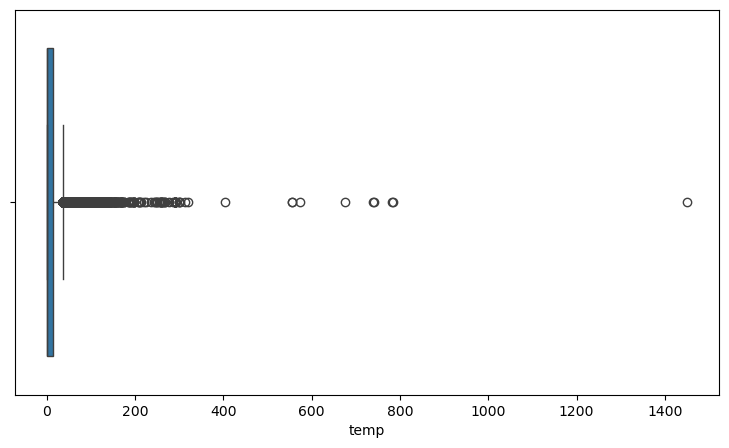

In [24]:
# check for durations data distribution
durations_cols =  ['purchase_to_approval', 'approval_to_carrier', 'carrier_to_customer', 'purchase_to_customer']

for dc in durations_cols:
  showDistributionCombo(orders_df.assign(temp=orders_df[dc] / 3600), 'temp', dc.replace('_', ' ', -1).capitalize() + ' (hours)')

Most orders follow a **tight and consistent delivery timeline**, as indicated by the sharp peaks near zero in all distributions—especially in the `purchase_to_approval` and `approval_to_carrier` durations. However, there are **significant long-tail outliers**, and in the case of `approval_to_carrier`, even **negative values**, which are logically invalid (a carrier date before approval doesn’t make sense). These likely stem from either data entry errors or system timestamp issues and should be carefully handled or removed.

In [ ]:
# 1. Negative value removal
orders_df = orders_df[orders_df['approval_to_carrier']>=0]
orders_df = orders_df[orders_df['carrier_to_customer']>=0]

# remove outliers with IQR
for dc in durations_cols:
	Q1 = orders_df[dc].quantile(0.25)
	Q3 = orders_df[dc].quantile(0.75)
	IQR = Q3 - Q1

	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR

	orders_df = orders_df[(orders_df[dc] >= lower_bound) & (orders_df[dc] <= upper_bound)]

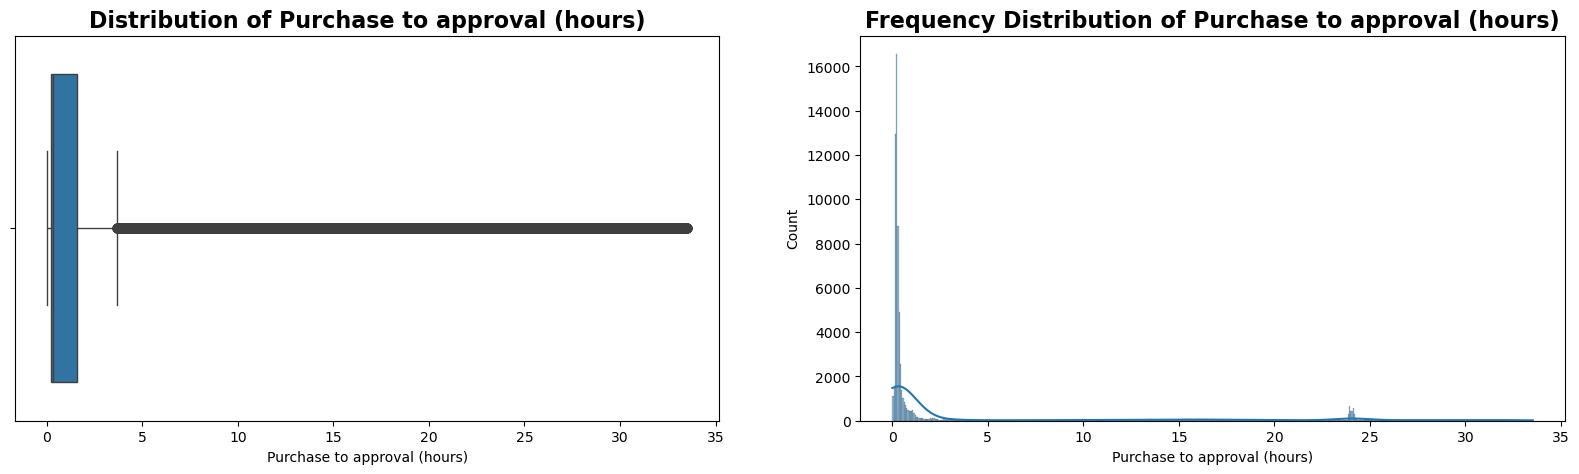

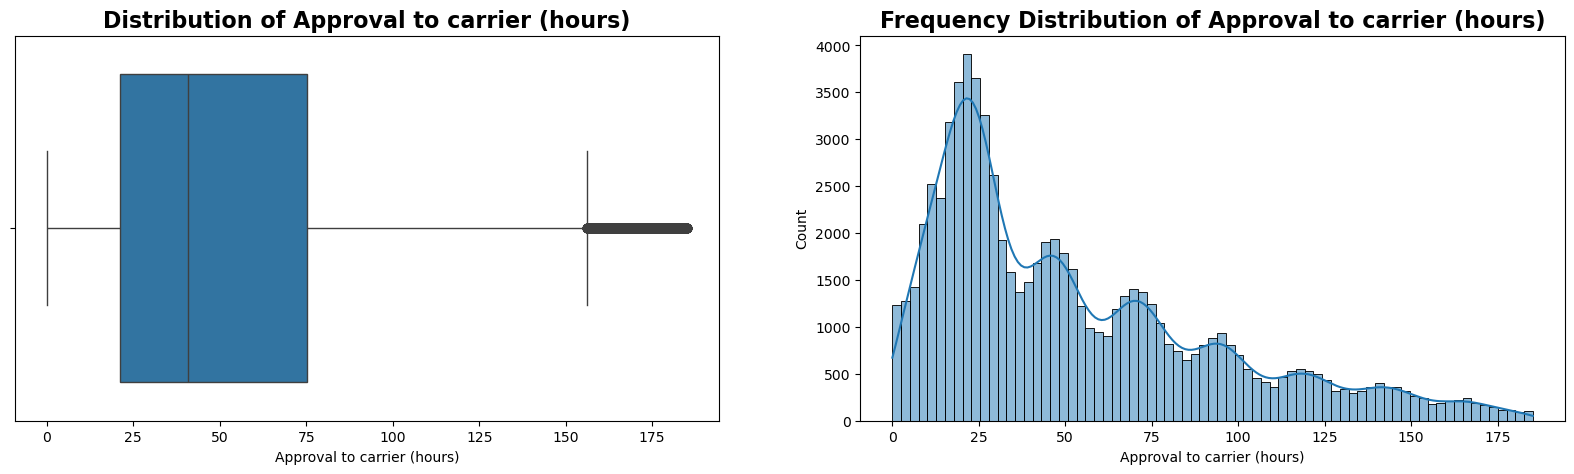

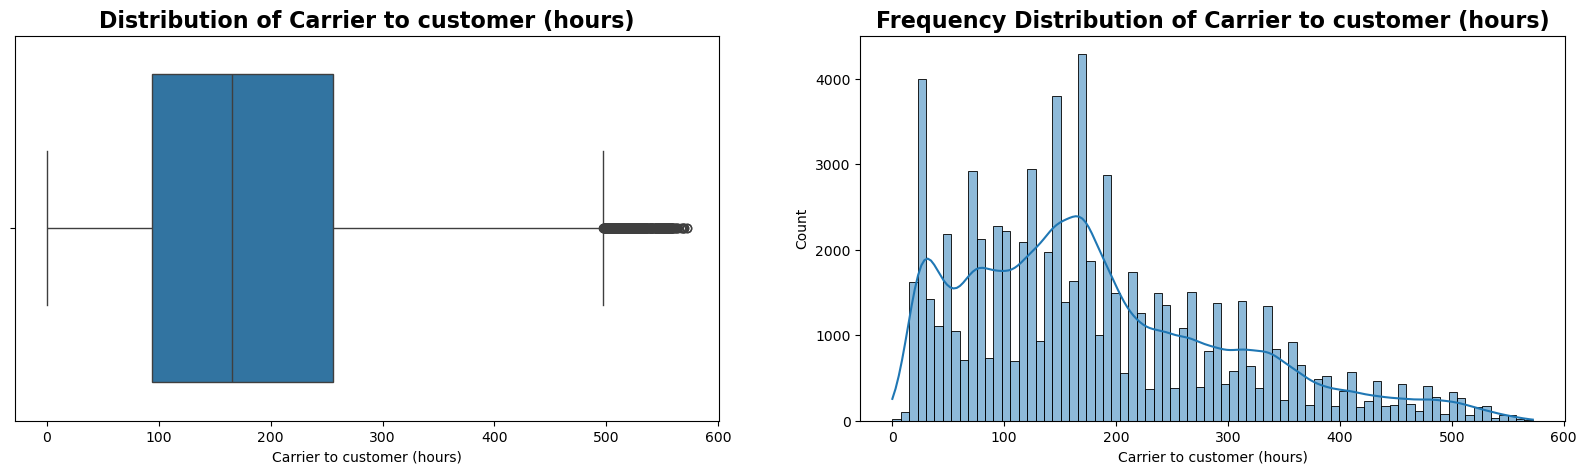

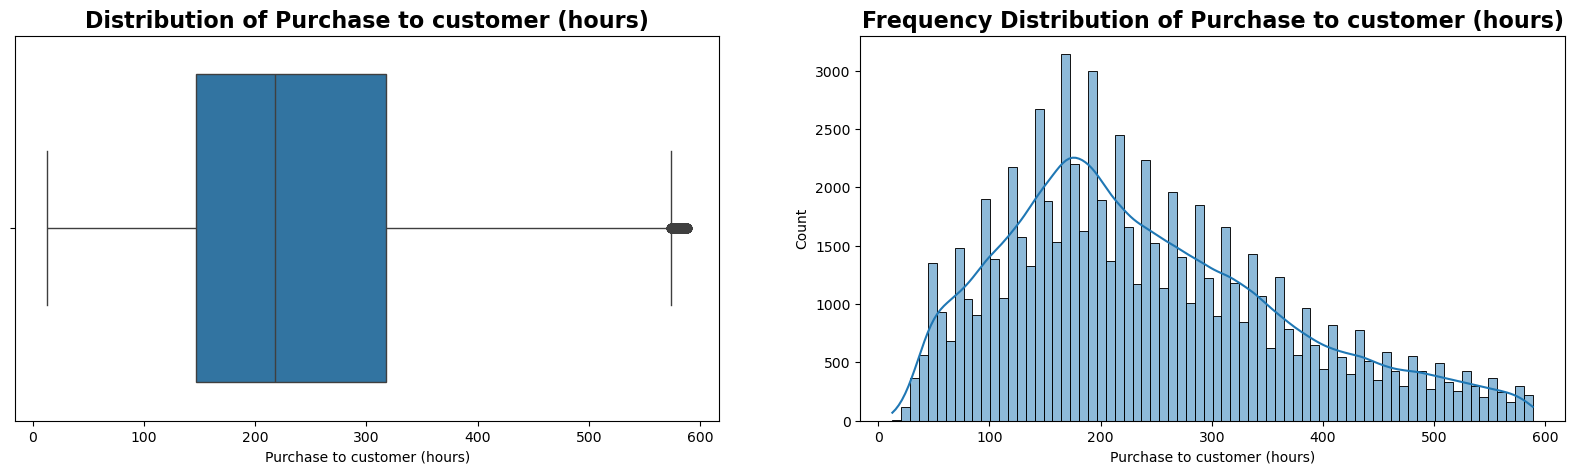

In [ ]:
# show final distribution
for dc in durations_cols:
  showDistributionCombo(orders_df.assign(temp=orders_df[dc] / 3600), 'temp', dc.replace('_', ' ', -1).capitalize() + ' (hours)')

#### Save Data

In [ ]:
orders_df.to_csv('./dataset/cleaned/olist_orders-cleaned.csv')

### **Order Items Dataset**

**`olist_order_items_dataset.csv` (112,650 rows)**

| Column Name           | Data Type        | Description                                                |
| --------------------- | ---------------- | ---------------------------------------------------------- |
| `order_id`            | `object`/`string`         | Identifier linking to the order.                           |
| `order_item_id`       | `int64`          | Sequential number identifying items within the same order. |
| `product_id`          | `object`/`string`         | Identifier for the purchased product.                      |
| `seller_id`           | `object`/`string`         | Identifier for the seller of the product.                  |
| `shipping_limit_date` | `datetime64` | Latest date the seller should ship the item.               |
| `price`               | `float64`        | Price paid for the item.                                   |
| `freight_value`       | `float64`        | Shipping cost charged for the item.                        |


In [ ]:
order_items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


#### Unique Values

In [ ]:
showUniqueValues(order_items_df, 6999)

,Column Name,Number of Unique,Unique Sample
6,freight_value,6999,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2, 0.21, 0.25, 0.28, 0.29, 0.31, 0.32, 0.33, 0.34, 0.37, 0.4, 0.45, 0.47, 0.48, 0.53, 0.56, 0.58, 0.61, 0.62, 0.63, 0.65, 0.69, 0.75, 0.76, 0.78, 0.8, 0.82, 0.83, 0.86, 0.88, 0.91, 0.92, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.04, 1.05, 1.06, 1.08, 1.09, 1.1, 1.12, 1.14, 1.15, 1.18, 1.2, 1.22, 1.24, 1.26, 1.27, 1.28, 1.3, 1.32, 1.33, 1.34, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.43, 1.44, 1.45, 1.46, 1.48, 1.51, 1.52, 1.55, 1.57, 1.58, 1.61, 1.64, 1.66, 1.67, 1.68, 1.69, 1.7, 1.71, 1.72, 1.73, ...]"
5,price,5968,"[0.85, 1.2, 2.2, 2.29, 2.9, 2.99, 3.0, 3.06, 3.49, 3.5, 3.54, 3.85, 3.9, 3.98, 3.99, 4.2, 4.3, 4.4, 4.5, 4.78, 4.85, 4.9, 4.99, 5.0, 5.18, 5.2, 5.3, 5.31, 5.35, 5.4, 5.49, 5.5, 5.53, 5.6, 5.7, 5.73, 5.85, 5.9, 5.95, 5.99, 6.0, 6.04, 6.1, 6.12, 6.15, 6.19, 6.25, 6.27, 6.3, 6.33, 6.35, 6.37, 6.49, 6.5, 6.57, 6.8, 6.84, 6.9, 6.99, 7.0, 7.09, 7.12, 7.18, 7.29, 7.3, 7.45, 7.48, 7.49, 7.5, 7.59, 7.6, 7.63, 7.65, 7.68, 7.78, 7.79, 7.8, 7.84, 7.87, 7.9, 7.96, 7.99, 8.0, 8.03, 8.09, 8.1, 8.2, 8.25, 8.33, 8.43, 8.45, 8.49, 8.5, 8.59, 8.6, 8.65, 8.68, 8.7, 8.73, 8.76, ...]"
3,seller_id,3095,"[0015a82c2db000af6aaaf3ae2ecb0532, 001cca7ae9ae17fb1caed9dfb1094831, 001e6ad469a905060d959994f1b41e4f, 002100f778ceb8431b7a1020ff7ab48f, 003554e2dce176b5555353e4f3555ac8, 004c9cd9d87a3c30c522c48c4fc07416, 00720abe85ba0859807595bbf045a33b, 00ab3eff1b5192e5f1a63bcecfee11c8, 00d8b143d12632bad99c0ad66ad52825, 00ee68308b45bc5e2660cd833c3f81cc, 00fc707aaaad2d31347cf883cd2dfe10, 010543a62bd80aa422851e79a3bc7540, 010da0602d7774602cd1b3f5fb7b709e, 011b0eaba87386a2ae96a7d32bb531d1, 01266d4c46afa519678d16a8b683d325, 013900e863eace745d3ec7614cab5b1a, 014c0679dd340a0e338872e7ec85666a, 014d9a685fd57276679edd00e07089e5, 0176f73cc1195f367f7b32db1e5b3aa8, 01bcc9d254a0143f0ce9791b960b2a47, 01c97ebb5cdac52891c0ed1c37ba0012, 01cf7e3d21494c41fb86034f2e714fa1, 01ed254b9ff8407dfb9d99ba1e17d923, 01fd077212124329bac32490e8ef80d9, 01fdefa7697d26ad920e9e0346d4bd1b, 0241d4d5d36f10f80c644447315af0bd, 0249d282d911d23cb8b869ab49c99f53, 024b564ae893ce8e9bfa02c10a401ece, 028872bfa080090a9d0abd4f1af168f8, 02a2272692e13558373c66db98f05e2e, 02b72cdeb9cfcc429f1af6f4e3f3b737, 02c988090b766852e088c69d7fb3b551, 02d35243ea2e497335cd0f076b45675d, 02dcd3e8e25bee036e32512bcf175493, 02ecc2a19303f05e59ce133fd923fff7, 02f5837340d7eb4f653d676c7256523a, 02f623a8eb246f3c5f7c2f96462654e6, 0307f7565ff85b299b6e5ef162b1b1a9, 0336182e1b3e92f029d5354832045fdf, 034b9387752bfa309f350a70cd45ffa3, 038b75b729c8a9a04b0d07cba7eabe86, 039b29ff3b3473435d0cd59040575de9, 039e6ad9dae79614493083e241147386, 03a2a6dcbe45d639c4dc2a0d24769c40, 03bd479e1d9484cdb14104d3023f7321, 0417b067eeab773d2f7061a726dc477f, 042573af89b6d931f672efaf789d8358, 04308b1ee57b6625f47df1d56f00eedf, 0432ead42b6c8a0bdf68154add917fdf, 044668ccd5316b12a7cf0d54a156e3e9, 04843805947f0fc584fc1969b6e50fe7, 048c2757535328e0d7dac690ad3c0aae, 04aa0a1c5ce6b222003403a3e11c3cc0, 04aba03279157f6d4e0fe8ccaf21963c, 04e38a233f726ef161074ab1c9b0399a, 04ee0ec01589969663ba5967c0e0bdc0, 04fdea0c111866e6cf812f1570d6b5bd, 0509040ea3fe50071181bbc359eb7738, 052577151711aec5c744fe12e66db3e1, 054694fa03fe82cec4b7551487331d74, 056b4ada5bbc2c50cc7842547dda6b51, 0570350b23eda5444f8d1d9544932058, 05730013efda596306417c3b09302475, 058cb5aeb36d7c0fcae20fc85d5e0a59, 058fd0aa2bfdb2274e05e1ae971dabb6, 05a48cc8859962767935ab9087417fbb, 05a940b4ecae36cadfd8e93bd9c43257, 05aebce0b5c8f0d41b29b686f2d05fd3, 05ca864204d09595ae591b93ea9cf93d, 05d2173d43ea568aa0540eba70d2ca76, 05e107217c7266362fd44b75b2cd4cc4, 05f51e13da97139648b8125c31e5f51b, 05feb94f19d094d4b0f9281f0b1d4c99, 05ff92fedb5be47920fea08e501238b9, 062c325cd6a2b87845fab56b4ec2eeae, 062ce95fa2ad4dfaedfc79260130565f, 06532f10282704ef4c69168b914b77be, 06579cb253ecd5a3a12a9e6eb6bf8f47, 066a6914e1ebf3ea95a216c73a986b91, 0691148aee60ca47977c187804f935ae, 0692610d8abe24f

#### Handle Column Type

In [ ]:
# Change 'shipping_limit_date' into datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

#### Missing Values

In [ ]:
order_items_df.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

No missing values, no action needed.

#### Duplicates

In [ ]:
order_items_df.duplicated().sum()

0

No duplicates found, no action needed.

#### Feature Engineering

In [ ]:
order_items_df['shipping_limit_date_year'] = order_items_df['shipping_limit_date'].dt.year
order_items_df['shipping_limit_date_month'] = order_items_df['shipping_limit_date'].dt.month
order_items_df['shipping_limit_date_day'] = order_items_df['shipping_limit_date'].dt.day
order_items_df['shipping_limit_date_hour'] = order_items_df['shipping_limit_date'].dt.hour
order_items_df['shipping_limit_date_minute'] = order_items_df['shipping_limit_date'].dt.minute
order_items_df['shipping_limit_date_second'] = order_items_df['shipping_limit_date'].dt.second

#### Unrealistic Values/Outliers

In [ ]:
# check date - year values
order_items_df['shipping_limit_date_year'].value_counts()

shipping_limit_date_year
2018    62511
2017    49765
2016      370
2020        4
Name: count, dtype: int64

In [ ]:
order_items_df = order_items_df[order_items_df['shipping_limit_date_year'] < 2020]

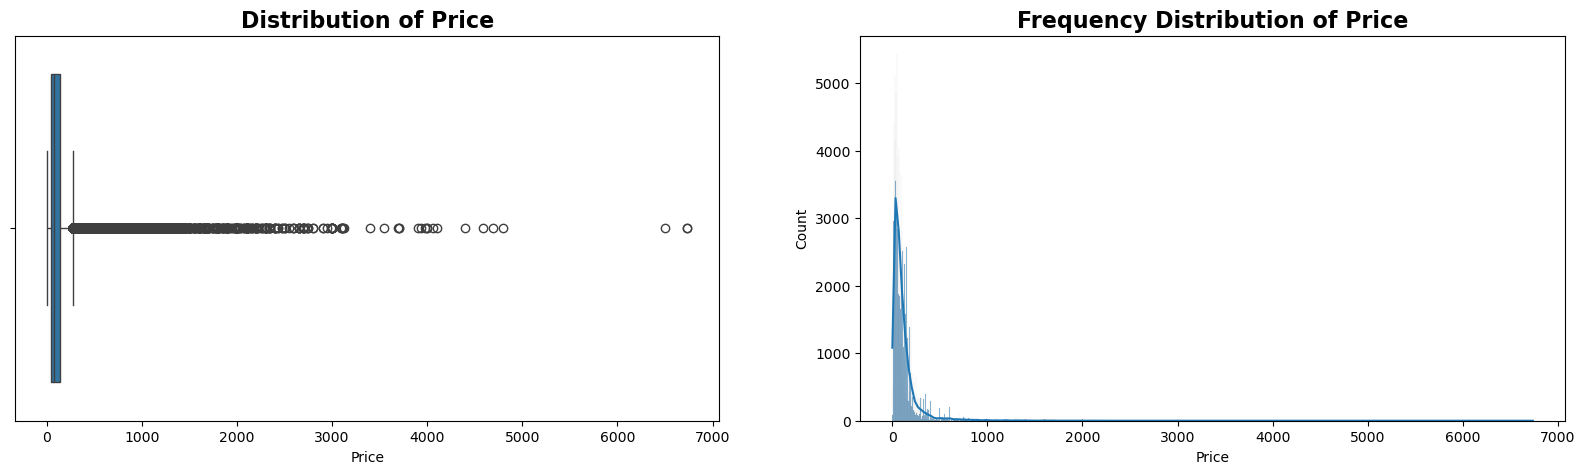

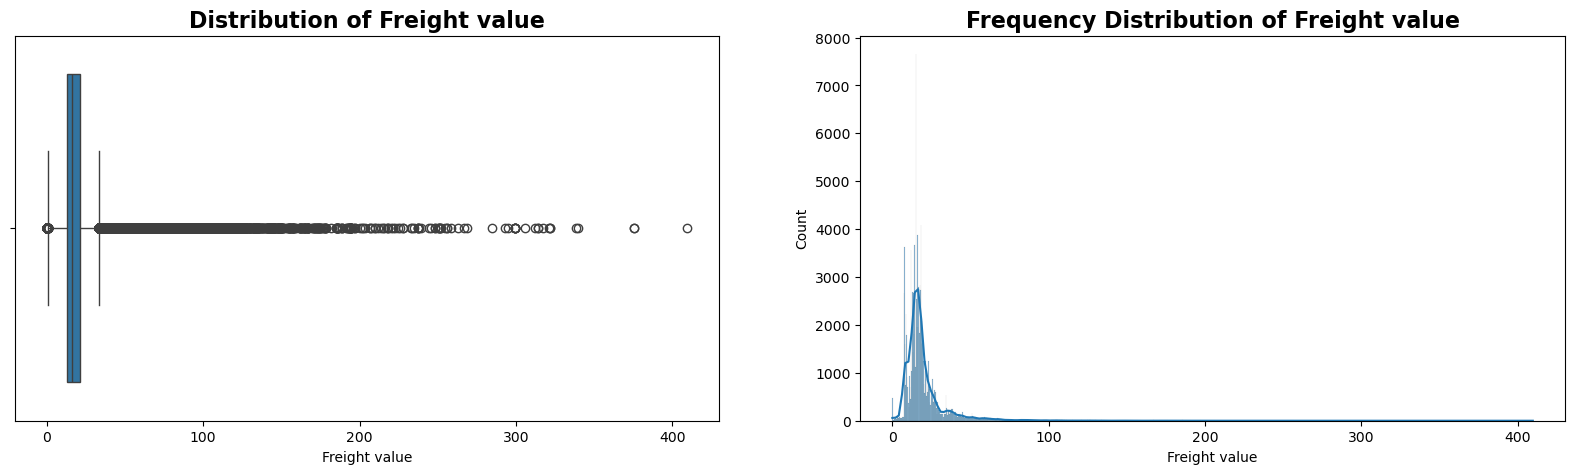

In [ ]:
# check price & freight value distribution
order_items_float_cols = ['price', 'freight_value']

for oifc in order_items_float_cols:
  showDistributionCombo(order_items_df, oifc, oifc.replace('_', ' ', -1).capitalize())

The visualizations highlight that both `price` and `freight_value` are highly right-skewed with a dense concentration of values near the lower range and a long tail of high-value outliers. The boxplots clearly show numerous outliers extending beyond the whiskers, while the histograms indicate that most data points lie under ~500 BRL for price and ~50 BRL for freight value. To clean this data, the **Interquartile Range (IQR)** method is recommended for removing outliers.


In [ ]:
# remove outliers with IQR
for oifc in order_items_float_cols:
	Q1 = order_items_df[oifc].quantile(0.25)
	Q3 = order_items_df[oifc].quantile(0.75)
	IQR = Q3 - Q1

	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR

	order_items_df = order_items_df[(order_items_df[oifc] >= lower_bound) & (order_items_df[oifc] <= upper_bound)]

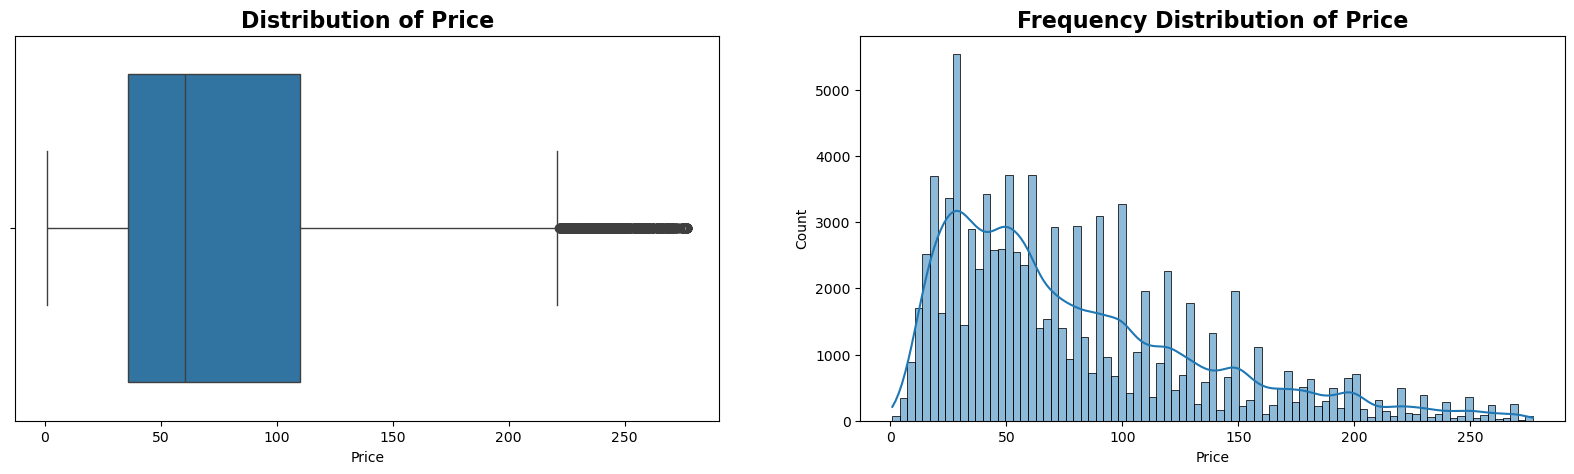

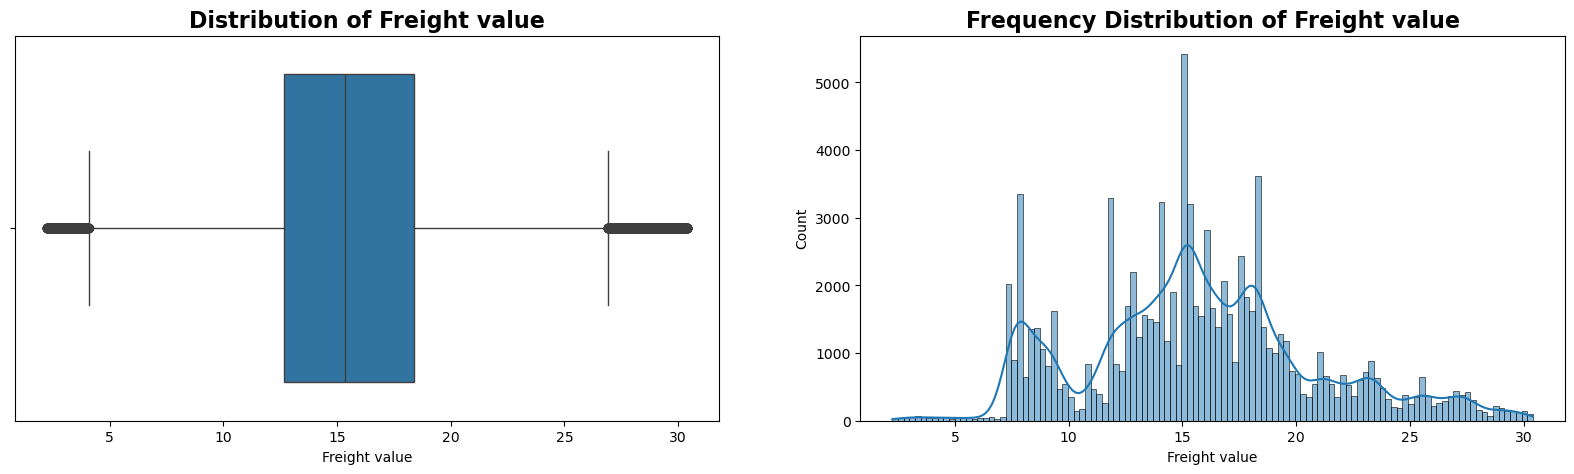

In [ ]:
for oifc in order_items_float_cols:
  showDistributionCombo(order_items_df, oifc, oifc.replace('_', ' ', -1).capitalize())

#### Save Data

In [ ]:
order_items_df.to_csv('./dataset/cleaned/olist_order_items-cleaned.csv')

### **Order Payments**

**`olist_order_payments_dataset.csv` (103,886 rows)**

| Column Name            | Data Type | Description                                                         |
| ---------------------- | --------- | ------------------------------------------------------------------- |
| `order_id`             | `object`/`string`  | Identifier linking to the order.                                    |
| `payment_sequential`   | `int64`   | Sequential number identifying multiple payments for the same order. |
| `payment_type`         | `object`/`string`  | Payment method used (e.g., credit card, boleto).                    |
| `payment_installments` | `int64`   | Number of installments for the payment.                             |
| `payment_value`        | `float64` | Total amount paid in the transaction.                               |

In [ ]:
order_payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


#### Unique Values

In [ ]:
showUniqueValues(order_payments_df, 29077)

,Column Name,Number of Unique,Unique Sample
4,payment_value,29077,"[0.0, 0.01, 0.03, 0.05, 0.07, 0.08, 0.09, 0.1, 0.11, 0.13, 0.14, 0.15, 0.16, 0.17, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.31, 0.32, 0.33, 0.34, 0.36, 0.37, 0.38, 0.39, 0.41, 0.42, 0.43, 0.44, 0.47, 0.48, 0.49, 0.52, 0.53, 0.54, 0.55, 0.56, 0.58, 0.59, 0.6, 0.61, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.72, 0.73, 0.74, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.91, 0.92, 0.93, 0.94, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.14, 1.15, 1.16, 1.17, 1.18, 1.2, 1.21, 1.22, 1.23, ...]"
1,payment_sequential,29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]"
3,payment_installments,24,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24]"
2,payment_type,5,"[boleto, credit_card, debit_card, not_defined, voucher]"


#### Handle Column Type

In [ ]:
# Change 'shipping_limit_date' into datetime
order_items_df['shipping_limit_date'] = pd.to_datetime(order_items_df['shipping_limit_date'])

#### Missing Values

In [ ]:
order_payments_df.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

#### Duplicates

In [ ]:
order_payments_df.duplicated().sum()

0

#### Unrealistic Values/Outliers

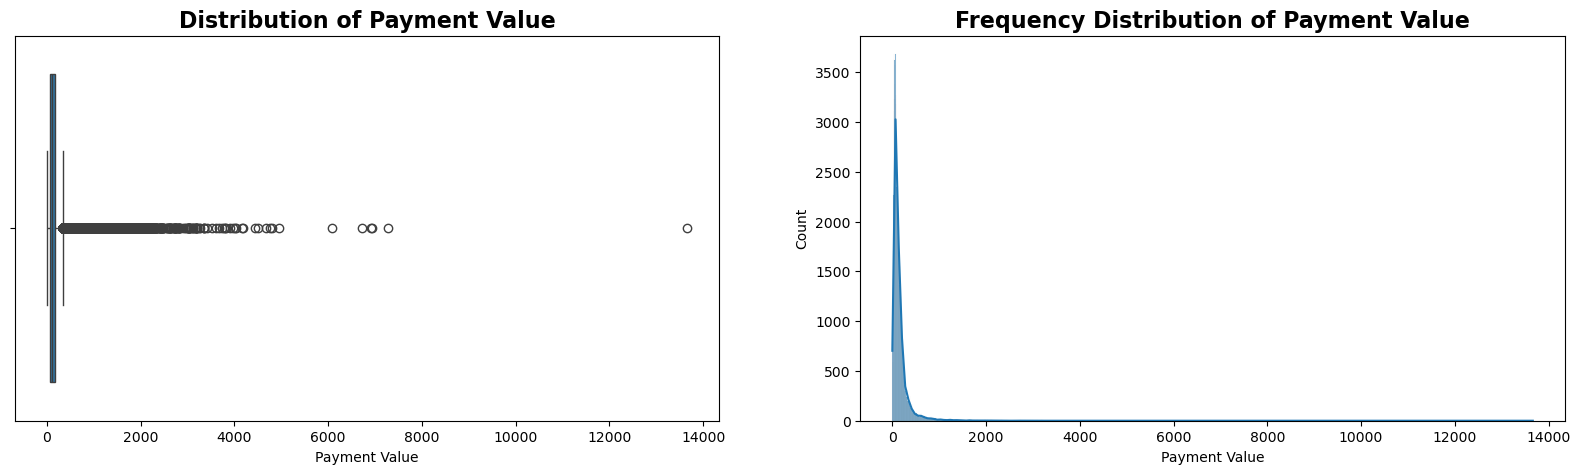

In [ ]:
showDistributionCombo(order_payments_df, 'payment_value', 'Payment Value')

The visualization of `payment_value` shows a strong right skew, where most transactions fall below 1,000, while a small number of extreme values reach up to nearly 14,000. The box plot confirms a dense cluster of lower values with many outliers extending far beyond the upper whisker, indicating significant variability among a few high-value orders. Though it might be important, we will remove all data above **6000**.

In [ ]:
order_payments_df = order_payments_df[order_payments_df['payment_value'] <= 6000]

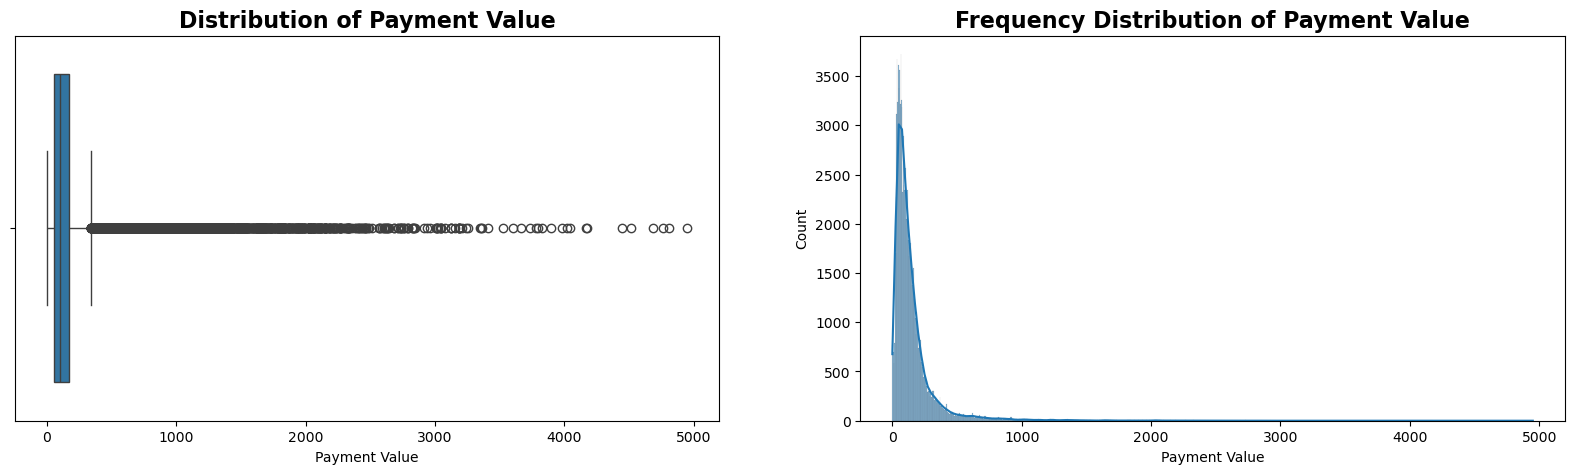

In [ ]:
showDistributionCombo(order_payments_df, 'payment_value', 'Payment Value')

In [ ]:
# check payment type count
order_payments_df['payment_type'].value_counts()

payment_type
credit_card    76793
boleto         19780
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

The `payment_type` distribution is dominated by credit card transactions, followed by boleto, voucher, and debit card payments. All categories appear valid and interpretable, except for the `not_defined` type, which lacks meaningful context or frequency to support analysis. Therefore, we will remove entries with `not_defined` as their payment type to maintain data quality and ensure consistency in further analysis.

#### Save Data

In [ ]:
order_payments_df.to_csv('./dataset/cleaned/olist_order_payments-cleaned.csv')

### **Order Reviews Dataset**

**`olist_order_reviews_dataset.csv` (100,000 rows)**

| Column Name               | Data Type        | Description                                           |
| ------------------------- | ---------------- | ----------------------------------------------------- |
| `review_id`               | `object`/`string`         | Unique identifier for each review.                    |
| `order_id`                | `object`/`string`         | Identifier linking to the order.                      |
| `review_score`            | `int64`          | Score given by the customer (1 to 5).                 |
| `review_comment_title`    | `object`/`string`         | Title of the review comment.                          |
| `review_comment_message`  | `object`/`string`         | Content of the review comment.                        |
| `review_creation_date`    | `object`/`string` | Date when the review was created.                     |
| `review_answer_timestamp` | `object`/`string` | Timestamp when the review was answered by the seller. |

In [ ]:
order_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


#### Unique Values

In [ ]:
showUniqueValues(order_reviews_df, 36159)

Column Name  Number of Unique  \
4  review_comment_message             36159   
3    review_comment_title              4527   
5    review_creation_date               636   
2            review_score                 5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

#### Handle Column Types

In [ ]:
# Change 'review_creation_date' & 'review_answer_timestamp' into datetime
order_reviews_df['review_creation_date'] = pd.to_datetime(order_reviews_df['review_creation_date'])
order_reviews_df['review_answer_timestamp'] = pd.to_datetime(order_reviews_df['review_answer_timestamp'])

#### Missing Values

In [ ]:
order_reviews_df.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

We can see that there are loads of missing values in the title & message sections, which is expected. To handle this we will be changing these values to an empty string.

In [ ]:
order_reviews_df['review_comment_title'] = order_reviews_df['review_comment_title'].fillna("")
order_reviews_df['review_comment_message'] = order_reviews_df['review_comment_message'].fillna("")

#### Duplicates

In [ ]:
order_reviews_df.duplicated().sum()

0

#### Feature Engineering

In [ ]:
review_dt_cols = ['review_creation_date', 'review_answer_timestamp']

for rdc in review_dt_cols:
	order_reviews_df[f'{rdc}_year'] = order_reviews_df[rdc].dt.year
	order_reviews_df[f'{rdc}_month'] = order_reviews_df[rdc].dt.month
	order_reviews_df[f'{rdc}_day'] = order_reviews_df[rdc].dt.day
	order_reviews_df[f'{rdc}_hour'] = order_reviews_df[rdc].dt.hour
	order_reviews_df[f'{rdc}_minute'] = order_reviews_df[rdc].dt.minute
	order_reviews_df[f'{rdc}_second'] = order_reviews_df[rdc].dt.second

#### Save Data

In [ ]:
order_reviews_df.to_csv('./dataset/cleaned/olist_review-cleaned.csv')

#### Unrealistic Values/Outliers

In [ ]:
# check for unique timestamp data
for rdc in review_dt_cols:
  print(order_reviews_df[f'{rdc}_year'].value_counts(), '\n')

review_creation_date_year
2018    56164
2017    42735
2016      325
Name: count, dtype: int64 

review_answer_timestamp_year
2018    56843
2017    42070
2016      311
Name: count, dtype: int64 



In [ ]:
for rdc in review_dt_cols:
  print(order_reviews_df[f'{rdc}_hour'].value_counts(), '\n')

review_creation_date_hour
0    99139
1       85
Name: count, dtype: int64 

review_answer_timestamp_hour
23    6982
11    6938
0     6487
12    6411
21    5885
22    5795
1     5718
13    5370
19    5081
20    5071
10    4987
14    4926
18    4357
15    4327
17    4235
16    4212
2     3778
9     2679
3     2320
4     1136
8     1062
5      576
7      467
6      424
Name: count, dtype: int64 



### **Products Dataset**

**`olist_products_dataset.csv` (32,951 rows)**

| Column Name                  | Data Type | Description                                   |
| ---------------------------- | --------- | --------------------------------------------- |
| `product_id`                 | `object`/`string`  | Unique identifier for each product.           |
| `product_category_name`      | `object`/`string`  | Category of the product (in Portuguese).      |
| `product_name_lenght`        | `float64` | Length of the product name.                   |
| `product_description_lenght` | `float64` | Length of the product description.            |
| `product_photos_qty`         | `float64` | Number of photos associated with the product. |
| `product_weight_g`           | `float64` | Weight of the product in grams.               |
| `product_length_cm`          | `float64` | Length of the product package in centimeters. |
| `product_height_cm`          | `float64` | Height of the product package in centimeters. |
| `product_width_cm`           | `float64` | Width of the product package in centimeters.  |

In [ ]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


#### Unique Values

In [ ]:
showUniqueValues(products_df, 2960)

,Column Name,Number of Unique,Unique Sample
3,product_description_lenght,2960,"[4.0, 8.0, 15.0, 20.0, 23.0, 26.0, 27.0, 28.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, ...]"
5,product_weight_g,2204,"[0.0, 2.0, 25.0, 50.0, 53.0, 54.0, 55.0, 58.0, 60.0, 61.0, 63.0, 65.0, 67.0, 70.0, 75.0, 76.0, 77.0, 78.0, 80.0, 82.0, 83.0, 85.0, 87.0, 88.0, 90.0, 91.0, 92.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 102.0, 103.0, 104.0, 105.0, 107.0, 108.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 132.0, 133.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 160.0, 161.0, 162.0, 163.0, 165.0, 166.0, 167.0, 169.0, 170.0, 171.0, 172.0, 173.0, 175.0, 177.0, 178.0, 179.0, 180.0, ...]"
7,product_height_cm,102,"[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 102.0, 103.0, ...]"
6,product_length_cm,99,"[7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, nan]"
8,product_width_cm,95,"[6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 90.0, 91.0, 92.0, 93.0, 95.0, 97.0, 98.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 118.0, nan]"
1,product_category_name,73,"[agro_industria_e_comercio, alimentos, alimentos_bebidas, artes, artes_e_artesanato, artigos_de_festas, artigos_de_natal, audio, automotivo, bebes, bebidas, beleza_saude, brinquedos, cama_mesa_banho, casa_conforto, casa_conforto_2, casa_construcao, cds_dvds_musicais, cine_foto, climatizacao, consoles_games, construcao_ferramentas_construcao, construcao_ferramentas_ferramentas, construcao_ferramentas_iluminacao, construcao_ferramentas_jardim, construcao_ferramentas_seguranca, cool_stuff, dvds_blu_ray, eletrodomesticos, eletrodomesticos_2, eletronicos, eletroportateis, esporte_lazer, fashion_bolsas_e_acessorios, fashion_calcados, fashion_esporte, fashion_roupa_feminina, fashion_roupa_infanto_juvenil, fa

#### Missing Values

In [ ]:
products_df.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Most of the values missing are floats, so we can change that to 0 or an empty string

In [ ]:
products_df['product_name_lenght'] = products_df['product_name_lenght'].fillna(0)
products_df['product_description_lenght'] = products_df['product_description_lenght'].fillna(0)
products_df['product_photos_qty'] = products_df['product_photos_qty'].fillna(0)
products_df['product_category_name'] = products_df['product_category_name'].fillna("")

#### Handle Column Types

In [ ]:
products_df['product_name_lenght'] = products_df['product_name_lenght'].astype(int)
products_df['product_description_lenght'] = products_df['product_description_lenght'].astype(int)
products_df['product_photos_qty'] = products_df['product_photos_qty'].astype(int)

Change floats into int.

#### Duplicates

In [ ]:
products_df.duplicated().sum()

0

#### Feature Engineering

In [ ]:
products_df['product_volume_cm3'] =  products_df['product_length_cm'] * products_df['product_height_cm'] * products_df['product_width_cm']

Add product volume calculation

#### Unrealistic Values/Outliers

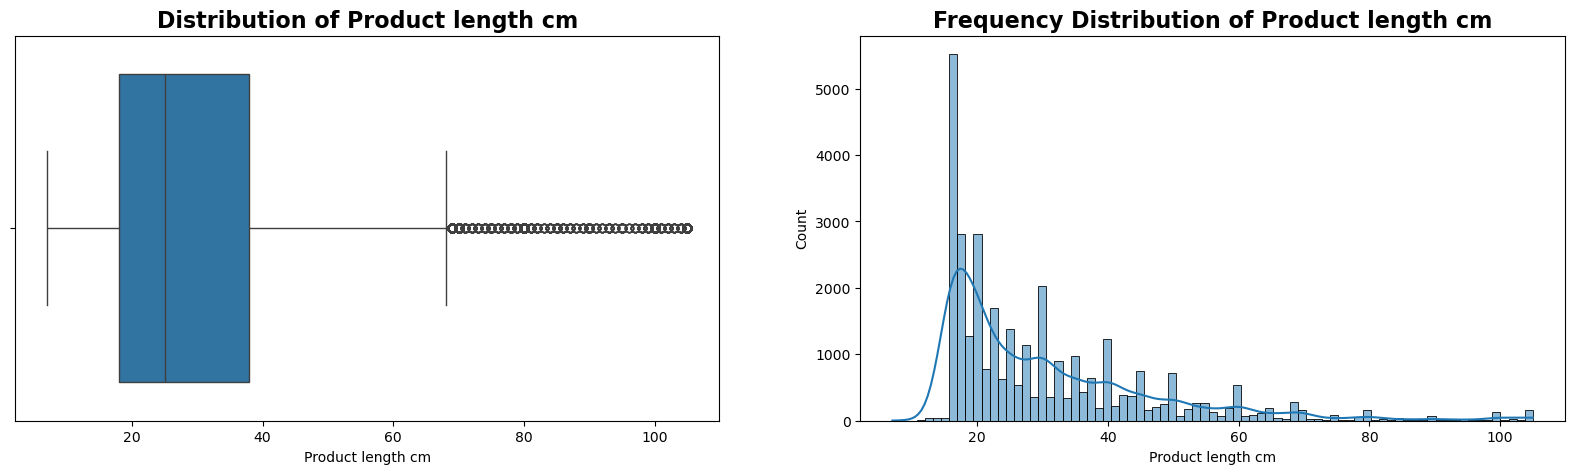

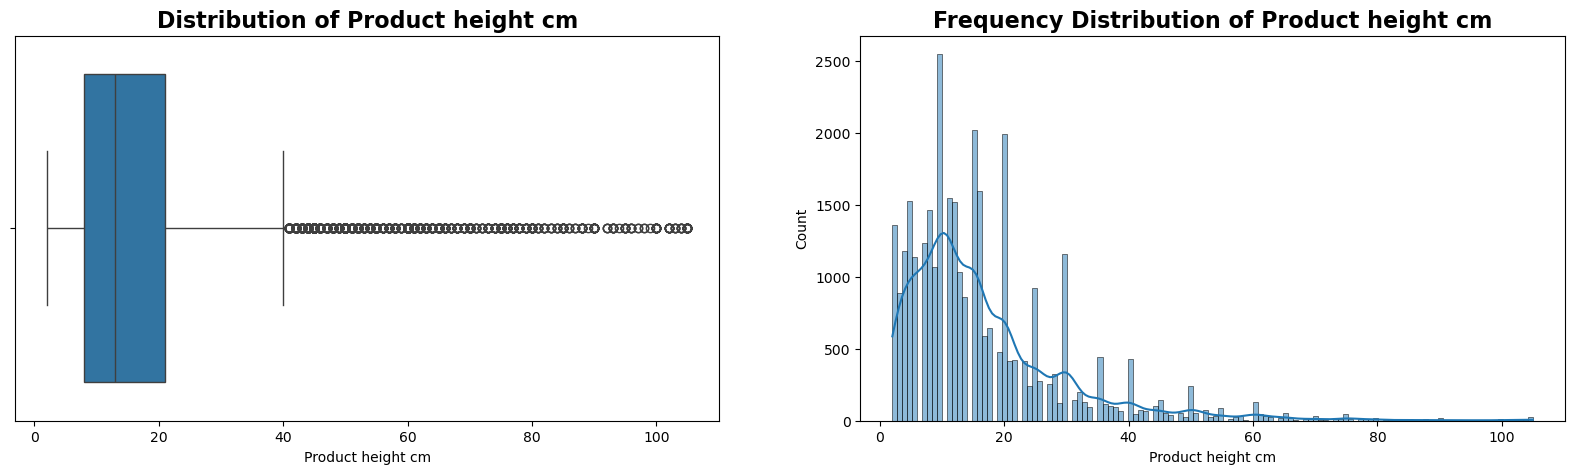

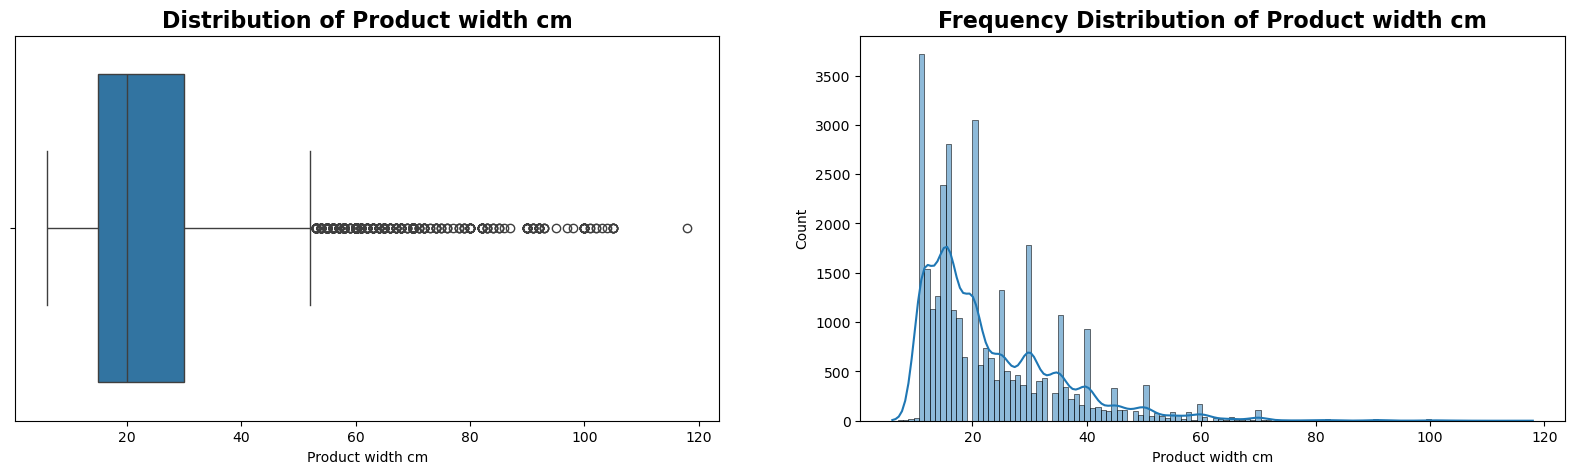

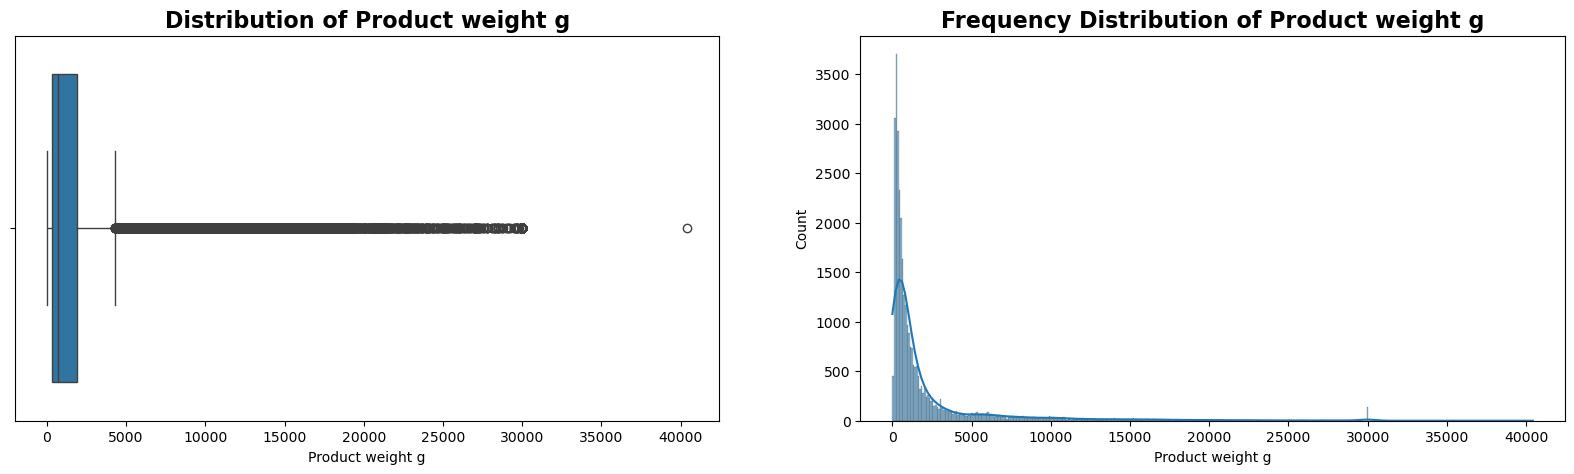

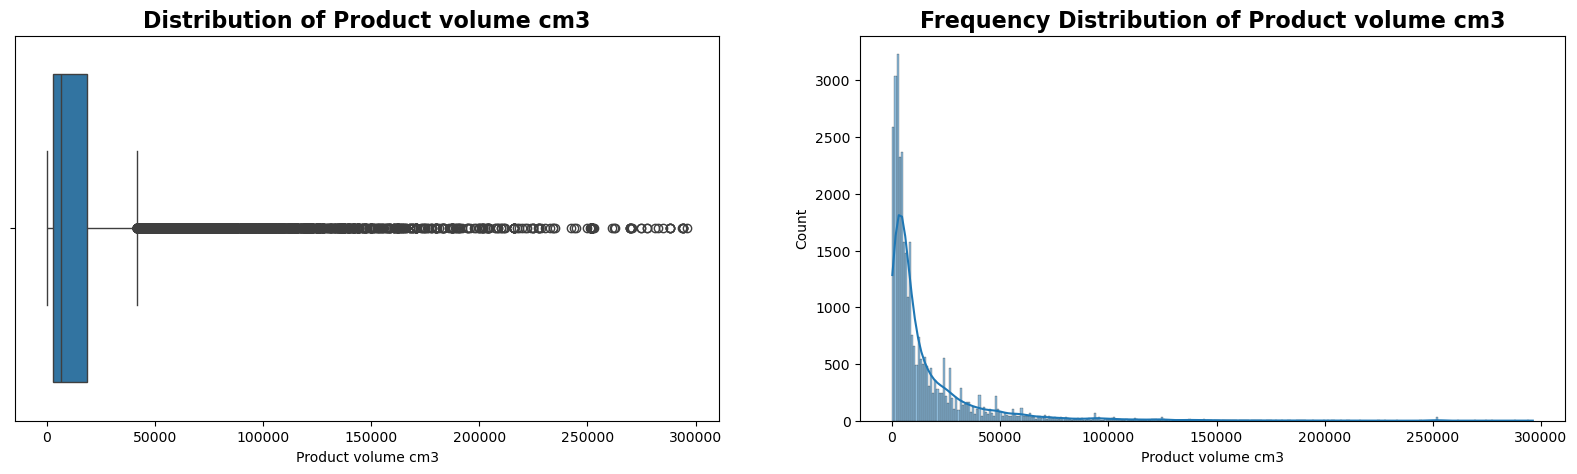

In [ ]:
# check price & freight value distribution
products_float_cols = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g', 'product_volume_cm3']

for oifc in products_float_cols:
  showDistributionCombo(products_df, oifc, oifc.replace('_', ' ', -1).capitalize())

Based on the charts we can see there are 2 distinct outliers on `product_weight_g` and `product_width_cm`. We can also see that the distribution of `volume` and `weight` is rather similar, which aligns logically. Let's take a look if the 2 outliers are the same row.

In [ ]:
products_df[(products_df['product_weight_g']>35000) | (products_df['product_width_cm']>112)]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3
25166,26644690fde745fc4654719c3904e1db,cama_mesa_banho,59,534,1,40425.0,13.0,65.0,28.0,23660.0
26970,b17808303e15dd50538c011b44295427,cama_mesa_banho,56,502,3,1050.0,23.0,93.0,118.0,252402.0


It appears that those are 2 different items. The products' data also does not look logical / realistic, according to their weights and volume. We will remove them.

In [ ]:
products_df['product_weight_g'] = products_df['product_weight_g']<35000
products_df['product_width_cm'] = products_df['product_width_cm']<112

#### Save Data

In [ ]:
products_df.to_csv('./dataset/cleaned/olist_products-cleaned.csv')

### **Sellers Dataset**


**`olist_sellers_dataset.csv` (3,095 rows)**

| Column Name              | Data Type | Description                                 |
| ------------------------ | --------- | ------------------------------------------- |
| `seller_id`              | `object`/`string`  | Unique identifier for each seller.          |
| `seller_zip_code_prefix` | `int64`   | First five digits of the seller's zip code. |
| `seller_city`            | `object`/`string`  | City where the seller is located.           |
| `seller_state`           | `object`/`string`  | State where the seller is located.          |

In [ ]:
sellers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


#### Unique Values

In [ ]:
showUniqueValues(sellers_df, 2246)

,Column Name,Number of Unique,Unique Sample
1,seller_zip_code_prefix,2246,"[1001, 1021, 1022, 1023, 1026, 1031, 1035, 1039, 1040, 1041, 1042, 1044, 1123, 1125, 1126, 1127, 1129, 1131, 1139, 1140, 1156, 1201, 1206, 1207, 1208, 1209, 1210, 1212, 1214, 1215, 1220, 1222, 1223, 1224, 1226, 1230, 1233, 1238, 1239, 1244, 1254, 1257, 1303, 1309, 1310, 1311, 1314, 1319, 1320, 1403, 1408, 1411, 1417, 1420, 1421, 1425, 1452, 1511, 1512, 1529, 1530, 1539, 1541, 1545, 1547, 1550, 1552, 2013, 2016, 2022, 2028, 2030, 2034, 2035, 2036, 2040, 2047, 2050, 2051, 2066, 2110, 2112, 2113, 2116, 2117, 2118, 2119, 2122, 2124, 2134, 2150, 2189, 2215, 2220, 2236, 2238, 2242, 2252, 2258, 2261, ...]"
2,seller_city,611,"[04482255, abadia de goias, afonso claudio, aguas claras df, alambari, alfenas, almirante tamandare, alvares machado, alvorada, americana, amparo, ampere, anapolis, andira-pr, andradas, angra dos reis, angra dos reis rj, ao bernardo do campo, aparecida, aparecida de goiania, aperibe, apucarana, aracaju, aracatuba, araguari, arapongas, araquari, ararangua, araraquara, araras, araucaria, araxa, arinos, armacao dos buzios, arraial d'ajuda (porto seguro), artur nogueira, aruja, arvorezinha, assis, atibaia, auriflama, auriflama/sp, avare, bady bassitt, baependi, bage, bahia, balenario camboriu, balneario camboriu, bandeirantes, barbacena, barbacena/ minas gerais, bariri, barra mansa, barra velha, barretos, barrinha, barro alto, barueri, batatais, bauru, bebedouro, belford roxo, belo horizont, belo horizonte, bento goncalves, bertioga, betim, birigui, blumenau, bocaiuva do sul, bofete, boituva, bom jardim, bom jesus dos perdoes, bombinhas, bonfinopolis de minas, borda da mata, botucatu, braco do norte, braganca paulista, brasilia, brasilia df, brejao, brotas, brusque, buritama, cacador, cachoeira do sul, cachoeirinha, cachoeiro de itapemirim, cafelandia, caieiras, cajamar, california, camanducaia, cambe, camboriu, campanha, campina das missoes, ...]"
3,seller_state,23,"[AC, AM, BA, CE, DF, ES, GO, MA, MG, MS, MT, PA, PB, PE, PI, PR, RJ, RN, RO, RS, SC, SE, SP]"


#### Missing Values

In [ ]:
sellers_df.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

#### Duplicates

In [ ]:
sellers_df.duplicated().sum()

0

#### Save Data

In [ ]:
sellers_df.to_csv('./dataset/cleaned/olist_sellers-cleaned.csv')

### **Others**

**`olist_geolocation_dataset.csv` (1,000,016 rows)**

| Column Name                   | Data Type | Description                          |
| ----------------------------- | --------- | ------------------------------------ |
| `geolocation_zip_code_prefix` | `int64`   | First five digits of the zip code.   |
| `geolocation_lat`             | `float64` | Latitude coordinate.                 |
| `geolocation_lng`             | `float64` | Longitude coordinate.                |
| `geolocation_city`            | `object`/`string`  | City corresponding to the zip code.  |
| `geolocation_state`           | `object`/`string`  | State corresponding to the zip code. |

<br>

**`product_category_name_translation.csv` (71 rows)**

| Column Name                     | Data Type | Description                          |
| ------------------------------- | --------- | ------------------------------------ |
| `product_category_name`         | `object`/`string`  | Product category name in Portuguese. |
| `product_category_name_english` | `object`/`string`  | Product category name in English.    |

### **Merge Tables**

In [ ]:
# translate product categories
final_products_df = products_df.merge(pcateg_translation_df, on='product_category_name', how='inner')
final_products_df = final_products_df.drop(columns=['product_category_name'])
final_products_df = final_products_df.rename(columns={'product_category_name_english': 'product_category_name'})

In [ ]:
final_products_df

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40,287,1,True,16.0,10.0,True,2240.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44,276,1,True,30.0,18.0,True,10800.0,art
2,96bd76ec8810374ed1b65e291975717f,46,250,1,True,18.0,9.0,True,2430.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27,261,1,True,26.0,4.0,True,2704.0,baby
4,9dc1a7de274444849c219cff195d0b71,37,402,4,True,20.0,17.0,True,4420.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32323,a0b7d5a992ccda646f2d34e418fff5a0,45,67,2,True,40.0,40.0,True,64000.0,furniture_decor
32324,bf4538d88321d0fd4412a93c974510e6,41,971,1,True,16.0,19.0,True,4864.0,construction_tools_lights
32325,9a7c6041fa9592d9d9ef6cfe62a71f8c,50,799,1,True,27.0,7.0,True,5103.0,bed_bath_table
32326,83808703fc0706a22e264b9d75f04a2e,60,156,2,True,31.0,13.0,True,8060.0,computers_accessories


In [ ]:
# order related data
merged_df = orders_df.merge(order_items_df, on='order_id', how='inner')
merged_df = merged_df.merge(order_payments_df, on='order_id', how='inner')
merged_df = merged_df.merge(order_reviews_df, on='order_id', how='inner')
merged_df = merged_df.merge(final_products_df, on='product_id', how='inner')

In [ ]:
merged_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp_year,order_purchase_timestamp_month,order_purchase_timestamp_day,order_purchase_timestamp_hour,order_purchase_timestamp_minute,order_purchase_timestamp_second,order_approved_at_year,order_approved_at_month,order_approved_at_day,order_approved_at_hour,order_approved_at_minute,order_approved_at_second,order_delivered_carrier_date_year,order_delivered_carrier_date_month,order_delivered_carrier_date_day,order_delivered_carrier_date_hour,order_delivered_carrier_date_minute,order_delivered_carrier_date_second,order_delivered_customer_date_year,order_delivered_customer_date_month,order_delivered_customer_date_day,order_delivered_customer_date_hour,order_delivered_customer_date_minute,order_delivered_customer_date_second,order_estimated_delivery_date_year,order_estimated_delivery_date_month,order_estimated_delivery_date_day,order_estimated_delivery_date_hour,order_estimated_delivery_date_minute,order_estimated_delivery_date_second,purchase_to_approval,approval_to_carrier,carrier_to_customer,purchase_to_customer,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,shipping_limit_date_year,shipping_limit_date_month,shipping_limit_date_day,shipping_limit_date_hour,shipping_limit_date_minute,shipping_limit_date_second,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_creation_date_year,review_creation_date_month,review_creation_date_day,review_creation_date_hour,review_creation_date_minute,review_creation_date_second,review_answer_timestamp_year,review_answer_timestamp_month,review_answer_timestamp_day,review_answer_timestamp_hour,review_answer_timestamp_minute,review_answer_timestamp_second,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_category_name
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18,0,0,0,642.0,204465.0,523813.0,728920.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017,10,6,11,7,15,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,2017,10,11,0,0,0,2017,10,12,3,43,48,40,268,4,True,19.0,8.0,True,1976.0,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,18,0,0,0,642.0,204465.0,523813.0,728920.0,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2017,10,6,11,7,15,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio correto e em boas condições. Apenas a caixa que veio bem amassada e danificada, o que ficará chato, pois se trata de um presente.",2017-10-11,2017-10-12 03:43:48,2017,10,11,0,0,0,2017,10,12,3,43,48,40,268,4,True,19.0,8.0,True,1976.0,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10,2,10,56,33,2017.0,10.0,2.0,11.0,7.0,15.0,2017.0,10.0,4.0,19.0,55.0,0.0,2017.0,10.0,10.0,21.0,25.0,13.0,2017,10,1

In [ ]:
# check dupes
print("Duplicates: ", merged_df.duplicated().sum())

# check missing value
print("isna: ", merged_df.isna().sum().sum())

Duplicates:  0
isna:  0


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75228 entries, 0 to 75227
Data columns (total 85 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   order_id                              75228 non-null  object        
 1   customer_id                           75228 non-null  object        
 2   order_status                          75228 non-null  object        
 3   order_purchase_timestamp              75228 non-null  datetime64[ns]
 4   order_approved_at                     75228 non-null  datetime64[ns]
 5   order_delivered_carrier_date          75228 non-null  datetime64[ns]
 6   order_delivered_customer_date         75228 non-null  datetime64[ns]
 7   order_estimated_delivery_date         75228 non-null  datetime64[ns]
 8   order_purchase_timestamp_year         75228 non-null  int32         
 9   order_purchase_timestamp_month        75228 non-null  int32         
 10

In [ ]:
merged_df.to_csv('./dataset/cleaned/olist_MERGED_clean.csv')

## **> Data Analysis**
<hr>

Before we can predict or prevent late deliveries, we must first define what "late" even means in Olist's ecosystem. The customer sees an estimated delivery date and expects their package by then — simple. But behind the scenes, multiple actors influence the outcome: sellers, warehouse delays, shipping providers, regional logistics.

To cut through the noise, we calculate two key metrics:

* **Delivery Delay**: the number of days between the estimated and actual delivery
* **Total Fulfillment Time**: how long it took from order placement to final delivery

These will form the backbone of our predictive insights.

In [ ]:
# Calculate delivery metrics
merged_df['delivery_delay'] = (merged_df['order_delivered_customer_date'] - merged_df['order_estimated_delivery_date']).dt.day
merged_df['actual_delivery_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days

Now that we have these two variables, we can better understand how delivery delay and overall fulfillment time influence customer reviews and whether an order is labeled as late. Let's take a look at how late orders affect cutomer ratings.

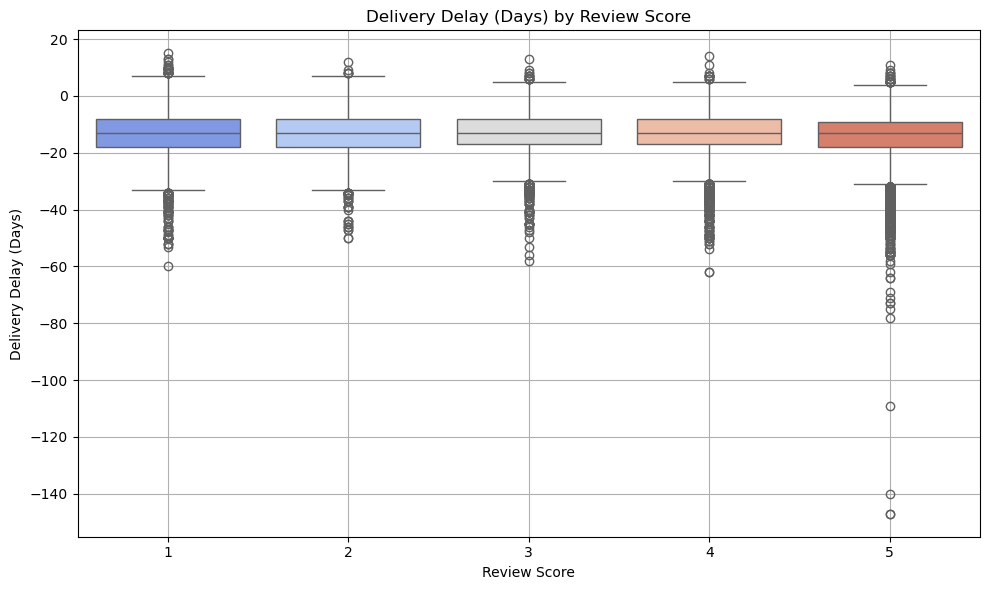

In [ ]:
filtered_df = merged_df

pltFigsize((10, 6))
sns.boxplot(data=filtered_df, x='review_score', y='delivery_delay', palette='coolwarm')
pltTitle('Delivery Delay (Days) by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Delay (Days)')
plt.grid(True)
plt.tight_layout()
plt.show()


This boxplot reveals a counterintuitive truth: **orders arriving earlier than expected don’t always lead to higher customer satisfaction**. Across all review scores — even 1-star ratings — deliveries are, on average, **early by 10 to 20 days**. That means customers are often unhappy **despite** fast shipping. The most negative reviews still share a median delay of around -20 days — just like the most positive ones.

What this tells us is crucial: **delivery speed alone doesn't guarantee a good customer experience**. While being late is still risky, this plot shows that the root of dissatisfaction likely lies **beyond logistics** — in product quality, seller communication, or unmet expectations. To improve customer happiness, Olist must look past speed and focus on **what happens inside the box** and how sellers handle the journey.

To have a deeper understanding, lets take a look at how delivery timing plays out across satisfaction levels. We'll have to categorize each order and count how many are early, on time, or late, broken down by review score.

In [ ]:
def classify_delay(days):
	if days > 0:
		return 'Late'
	elif days < 0:
		return 'Early'
	else:
		return 'On Time'

merged_df['delivery_status'] = merged_df['delivery_delay'].apply(classify_delay)

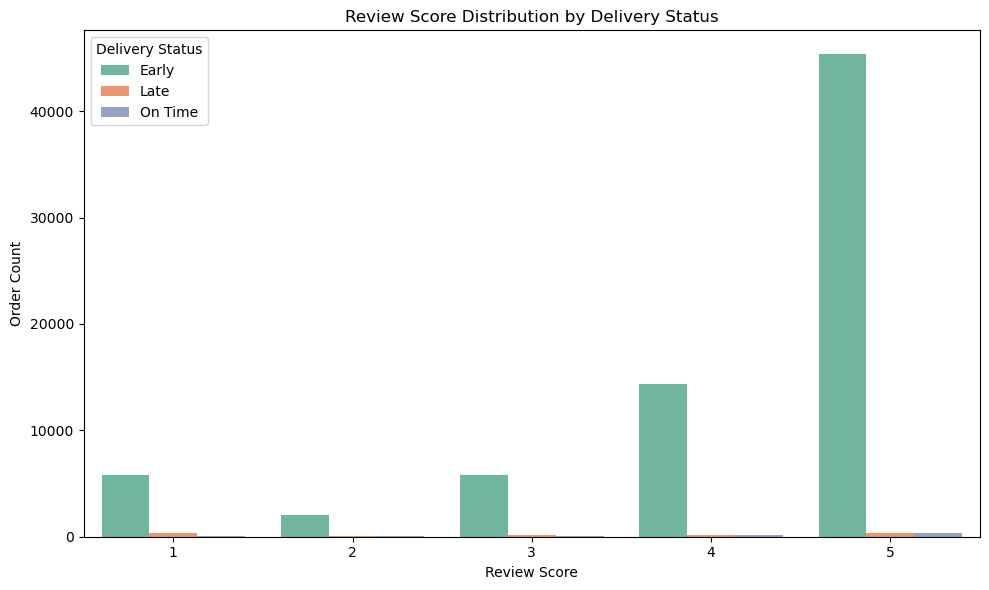

In [ ]:
pltFigsize((10, 6))
sns.countplot(data=merged_df, x='review_score', hue='delivery_status', palette='Set2')
pltTitle('Review Score Distribution by Delivery Status')
plt.xlabel('Review Score')
plt.ylabel('Order Count')
plt.legend(title='Delivery Status')
plt.tight_layout()
plt.show()


**Countplot Insight**
Here’s the clincher: the overwhelming majority of orders — including **nearly all 5-star reviews and a shocking number of 1-stars** — were delivered **early**. Late deliveries are rare across the board, and even where they occur, they don’t dominate the low-score zones. This firmly confirms the earlier insight: **customers aren’t just reacting to when the box shows up — they’re reacting to what’s inside, how it was handled, or how the experience felt.**

So if Olist wants to reduce 1-star reviews, it’s not enough to optimize shipping times. The company must turn its attention to **product integrity, seller accountability, and customer support follow-up** — because the clock isn’t the only thing ticking. Expectations are too. For now let's take a look at how `review_score` correlate with any other quantitative features.

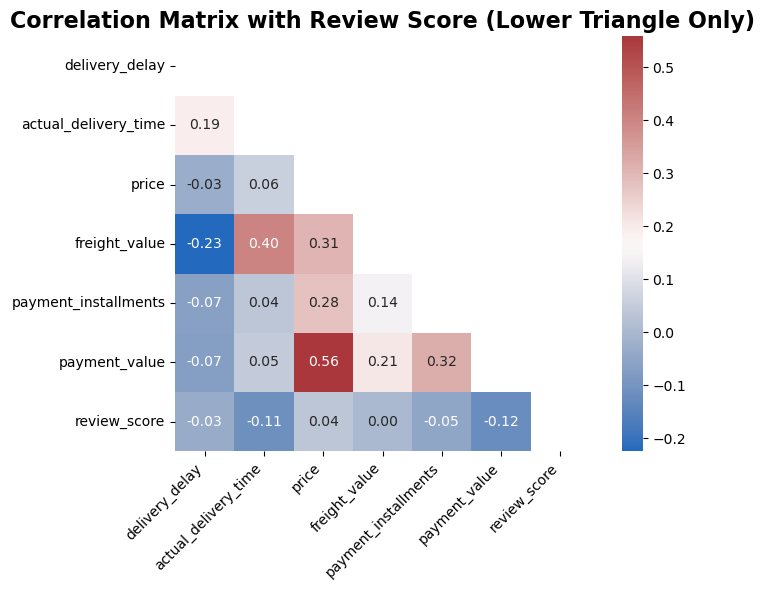

In [ ]:
features_to_corr = [
	'delivery_delay', 'actual_delivery_time',
	'price', 'freight_value', 'payment_installments', 'payment_value'
]

# Include review_score
corr = merged_df[features_to_corr + ['review_score']].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot with mask
pltFigsize((8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap='vlag', fmt=".2f", cbar=True, square=True)
pltTitle('Correlation Matrix with Review Score (Lower Triangle Only)')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Turns out that the correlation of `review_score` to other features are negligable. The relationship between `delivery_delay` and `review_score` is particularly weak, with a correlation of just -0.03, suggesting that late or early deliveries alone don’t significantly impact satisfaction. Other variables like `payment_value` **(-0.12)** and `actual_delivery_time` **(-0.11)** show slightly stronger—but still weak—negative correlations. Overall, these results suggest that operational metrics alone are not sufficient to predict customer satisfaction, pointing to the need for deeper insights into product quality, seller reliability, or customer expectations.